In [173]:
import time
import numpy as np
import os
import pandas as pd
import math
import cmath
from numpy import linalg as LA
# from numba import jit ##seems like it is not used in the code,
# import cupy as cp

In [174]:
#Choosing of units
hbar = 6.626e-34
k_B = 1.38e-23
a=1e-10 #choose lattice spacing

In [175]:
# Define constants for this problem
springconstantunit = 2.30986e26   # change of dimension: Lifa's 0.02394eV/amuA^2 to SI units
kl = springconstantunit    # lateral spring constant
kt = kl/4        #transverse spring constant


N = 120 # Number of sites in x direction ($""nu$) supposed to be 300
L = 40 # Number of sites in y direction (l) supposed to be 100

T_L = 10      # Left temperature in Kelvin
T_R = 80     # Right temperature in Kelvin

In [176]:
#construct Unitary Rotation Matrix
def RotationMatrix(phi):
    U = np.zeros((2, 2))
    U[0, 0] = math.cos(phi)
    U[0, 1] = -math.sin(phi)
    U[1, 0] = math.sin(phi)
    U[1, 1] = math.cos(phi)
    return U

In [177]:
#construct function to rotate spring constant matrix
def RotateMatrix(phi,K_0):
    U=RotationMatrix(phi)
    K_1=U@K_0@(U.T)
    return K_1

In [178]:
#Spring constant matrix for individual bonds
#K_0 is the horizontal spring, K_1 is rotated by 90degrees
def SpringConstantMatrices():
    K_0 = np.zeros((2, 2),dtype=complex)
    K_0[0, 0] =kl
    K_0[1, 1] =kt
    #fill in spring constant matrices
    K_1=RotateMatrix(math.pi/4,K_0)
    K_3=RotateMatrix(-math.pi/4,K_0)
    return K_0,K_1,K_3


In [179]:
def CellSpringConstantMatrix():
    K_0,K_1,K_3 = SpringConstantMatrices()
    K_nunuminus1 = np.zeros((2*L, 2*L), dtype=complex)
    K_nunu = np.zeros((2*L, 2*L), dtype=complex)
    K_nunuplus1 = np.zeros((2*L, 2*L), dtype=complex)
    #set up K_nunuminus1 which is 
    #-K_1 -K_O -K_3 
    #          -K_0 along tridiagonal
    for i in np.arange(L):
        p = 2 * i
        # Diagonal part
        K_nunuminus1[p, p] = -K_0[0, 0]
        K_nunuminus1[p+1, p+1] = -K_0[1, 1]
        #Left Diagonal part
        if i>0:
            if (i % 2) == 0:
                K_nunuminus1[p, p-2] = -K_1[0, 0]
                K_nunuminus1[p, p-1] = -K_1[0, 1]
                K_nunuminus1[p+1, p-2] = -K_1[1, 0]
                K_nunuminus1[p+1, p-1] = -K_1[1, 1]
        if i<(L-1):
            if (i % 2) == 0:
                K_nunuminus1[p, p+2] = -K_3[0, 0]
                K_nunuminus1[p, p+3] = -K_3[0, 1]
                K_nunuminus1[p+1, p+2] = -K_3[1, 0]
                K_nunuminus1[p+1, p+3] = -K_3[1, 1]

    
    #set up K_nunu which is -K_3 2K_0+2K_1 -K_1 for non extreme rows
    for i in np.arange(1,L-1):
        p = 2 * i
        #main Diagonal
        K_nunu[p, p] = 2*K_0[0, 0]+2*K_1[0, 0]+2*K_3[0, 0]
        K_nunu[p, p+1] = 2*K_0[0, 1]+2*K_1[0, 1]+2*K_3[0, 1]
        K_nunu[p+1, p] = 2*K_0[1, 0]+2*K_1[1, 0]+2*K_3[1, 0]
        K_nunu[p+1, p+1] = 2*K_0[1, 1]+2*K_1[1, 1]+2*K_3[1, 1]
        # left diagonal
        if i>0:
            if (i % 2) == 0:
                K_nunu[p, p-2] = -K_3[0, 0]
                K_nunu[p, p-1] = -K_3[0, 1]
                K_nunu[p+1, p-2] = -K_3[1, 0]
                K_nunu[p+1, p-1] = -K_3[1, 1]
            else:
                K_nunu[p, p-2] = -K_1[0, 0]
                K_nunu[p, p-1] = -K_1[0, 1]
                K_nunu[p+1, p-2] = -K_1[1, 0]
                K_nunu[p+1, p-1] = -K_1[1, 1]
        # right diagonal
        if i<(L-1):
            if (i % 2) == 0:
                K_nunu[p, p+2] = -K_1[0, 0]
                K_nunu[p, p+3] = -K_1[0, 1]
                K_nunu[p+1, p+2] = -K_1[1, 0]
                K_nunu[p+1, p+3] = -K_1[1, 1]
            else:
                K_nunu[p, p+2] = -K_3[0, 0]
                K_nunu[p, p+3] = -K_3[0, 1]
                K_nunu[p+1, p+2] = -K_3[1, 0]
                K_nunu[p+1, p+3] = -K_3[1, 1]
                
    #first row 2K_0+1K_1+1K_3 -K_1
    K_nunu[0,0] = 2*K_0[0, 0]+1*K_1[0, 0]+1*K_3[0, 0]
    K_nunu[0,1] = 2*K_0[0, 1]+1*K_1[0, 1]+1*K_3[0, 1]
    K_nunu[1,0] = 2*K_0[1, 0]+1*K_1[1, 0]+1*K_3[1, 0]
    K_nunu[1,1] = 2*K_0[1, 1]+1*K_1[1, 1]+1*K_3[1, 1]
    K_nunu[0, 2] = -K_1[0, 0]
    K_nunu[0, 3] = -K_1[0, 1]
    K_nunu[1, 2] = -K_1[1, 0]
    K_nunu[1, 3] = -K_1[1, 1]
    #last row -K_1 2K_0+1K_1+1K_3
    K_nunu[2*L-2,2*L-4] = -K_1[0, 0]
    K_nunu[2*L-2,2*L-3] = -K_1[0, 1]
    K_nunu[2*L-1,2*L-4] = -K_1[1, 0]
    K_nunu[2*L-1,2*L-3] = -K_1[1, 1]
    K_nunu[2*L-2,2*L-2] = 2*K_0[0, 0]+1*K_1[0, 0]+1*K_3[0, 0]
    K_nunu[2*L-2,2*L-1] = 2*K_0[0, 1]+1*K_1[0, 1]+1*K_3[0, 1]
    K_nunu[2*L-1,2*L-2] = 2*K_0[1,0]+1*K_1[1,0]+1*K_3[1,0]
    K_nunu[2*L-1,2*L-1] = 2*K_0[1,1]+1*K_1[1,1]+1*K_3[1,1]
    
    #set up K_nunuplus1 which is -K_O along diagonal
    for i in np.arange(L):
        p = 2 * i
        # Diagonal part
        K_nunuplus1[p, p] = -K_0[0, 0]
        K_nunuplus1[p+1, p+1] = -K_0[1, 1]
        #Left Diagonal part
        if i>0:
            if (i % 2) == 1:
                K_nunuplus1[p, p-2] = -K_3[0, 0]
                K_nunuplus1[p, p-1] = -K_3[0, 1]
                K_nunuplus1[p+1, p-2] = -K_3[1, 0]
                K_nunuplus1[p+1, p-1] = -K_3[1, 1]
        #right diagonal part
        if i<(L-1):
            if (i % 2) == 1:
                K_nunuplus1[p, p+2] = -K_1[0, 0]
                K_nunuplus1[p, p+3] = -K_1[0, 1]
                K_nunuplus1[p+1, p+2] = -K_1[1, 0]
                K_nunuplus1[p+1, p+3] = -K_1[1, 1]
#     #print("K_nunuminus1")
#     #print(np.round(K_nunuminus1,2))
#     #print("K_nunu")
#     #print(K_nunu)
#     #print("K_nunuplus1")
#     #print(K_nunuplus1)
    return K_nunuminus1,K_nunu,K_nunuplus1
#K_nunuminus1,K_nunu,K_nunuplus1=CellSpringConstantMatrix()

In [180]:
# # see Knnminus1 directly in csv file
# path = r'C:\\Users\\wuyiz\\Onedrive\\Desktop\\123'
# name = 'Knn.csv'
# b= np.round(K_nunu, 2)
# #print(b)
# np.savetxt(os.path.join(path, name), b, delimiter = ',')

In [181]:
#set up dynamic matrix
#refer to report for why Dynamic Matrix is independent of nu(due to translational invariance)
#therefore for simplicity we choose nu=0
def DynamicMatrix(q,K_nunuminus1,K_nunu,K_nunuplus1):
    D = np.zeros((2*L, 2*L), dtype=complex)
    D=K_nunuminus1*math.e**((0+1j)*q*a)+K_nunu+K_nunuplus1*math.e**(-(0+1j)*q*a)
    #print("D=")
    #print(np.round(D,2))
    return D

In [182]:
#construct eigenvectors
time_start = time.time()
K_nunuminus1,K_nunu,K_nunuplus1 = CellSpringConstantMatrix()
q = 0 #2*np.pi/(N*a) #(2*np.pi/(N*a)) #n here, n runs from 0 to N-1
#print('q')
#print(q)
#print(DynamicMatrix(q,K_nunuminus1,K_nunu,K_nunuplus1))
val1, vec1 = LA.eigh(DynamicMatrix(q,K_nunuminus1,K_nunu,K_nunuplus1))
#print('val1')
#print(val1)
#print(np.sqrt(np.round(val1,3)))
time_end = time.time()
#print('vec1')
#print(np.round(vec1,2))
#print('Time cost = %fs' % (time_end - time_start))

In [183]:
# check if dynamic matrix is Hermitian

Q = DynamicMatrix(q,K_nunuminus1,K_nunu,K_nunuplus1)
g = "Hermitian"
for i in range(2*L):
    for j in range(2*L):
        if np.allclose(np.conjugate(np.transpose(Q))[i,j],Q[i,j])== False:
            g="Not Hermitian"
            #print('%2.2f, %2.2f'%(i, j))
            #print(Q[i, j])
#print(g)

In [184]:
# # see dynamic matrix directly in csv file to display conveniently(to check if dynamic matrix is correct,
# # as the output cell is too small to #print each row of the matrix in a single output row for l>=4)
# path = r'C:\\Users\\wuyiz\\Onedrive\\Desktop\\123'
# name = 'data1.csv'
# b = np.round(vec1, 3)
# #print(b)
# np.savetxt(os.path.join(path, name), b, delimiter = ',')
# # name = 'data2.csv'
# # a = vec2
# # np.savetxt(os.path.join(path, name), a, delimiter = ',')

In [185]:
#differentiate D with respect to q for the next part
def delD(q,K_nunuminus1,K_nunu,K_nunuplus1):
    del_D=(0+1j)*a*K_nunuminus1*math.e**((0+1j)*q*a)-(0+1j)*a*K_nunuplus1*math.e**(-(0+1j)*q*a)
    #print("del_D=")
    #print(np.round(del_D,2))
    return del_D

In [186]:
def delminusD(q,K_nunuminus1,K_nunu,K_nunuplus1):
    del_minusD=-(0+1j)*a*K_nunuminus1*math.e**((0+1j)*q*a)+(0+1j)*a*K_nunuplus1*math.e**(-(0+1j)*q*a)
    #print("del_minusD=")
    #print(np.round(del_minusD,2))
    return del_minusD

In [187]:
def GroupVelocity(m,q,vecp,vecminusp,valp,del_D,del_minusD):
    #print("Group Velocity vecp[:, m-1]=")
    #print(np.round(vecp[:, m-1],2))
    #print('Group Velocity valp[m-1]')
    #print(np.round(valp[m-1],2))
    #print("cmath.sqrt(valp[m-1]=")
    #print(cmath.sqrt(valp[m-1]))
    v_m=0
    #print('q=')
    #print(q)
    #here m-1 because m runs from 1 to 2L but computer numbering starts from 0
    if q>0:
        v_m=(np.conjugate(vecp[:, m-1])@del_D@np.array([vecp[:, m-1]]).T)/(2*cmath.sqrt(valp[m-1]))
        #print("vecp[:, m-1]@del_D@np.array([vecp[:, m-1]]).T")
        #print(vecp[:, m-1]@del_D@np.array([vecp[:, m-1]]).T)
    elif q<0:
        v_m=(np.conjugate(vecminusp[:, m-1])@del_minusD@np.array([vecminusp[:, m-1]]).T)/(2*cmath.sqrt(valp[m-1]))
        #print('vecminusp[:, m-1]@del_D@np.array([vecminusp[:, m-1]]).T')
        #print(vecminusp[:, m-1]@del_D@np.array([vecminusp[:, m-1]]).T)
    #print("v_m")
    #print(v_m)
    return v_m

In [188]:
#define number operator
#package both number operators together, select each based on the group velocity
def Numberoperator(m,q,vecp,vecminusp,valp,del_D,del_minusD):
    v_m=GroupVelocity(m,q,vecp,vecminusp,valp,del_D,del_minusD)
    if v_m>0:
        number = 1/(math.e**(hbar * cmath.sqrt(valp[m-1])/(k_B*T_L))-1)
    elif v_m<0:
        number = 1/(math.e**(hbar * cmath.sqrt(valp[m-1])/(k_B*T_R))-1)
    elif v_m==0:
        number=0 #this is because there is no transport, so there are no phonons
    #print('number=')
    #print(number)
    return number

In [189]:
def A_m(l,m,vecp,vecminusp):
    am=0
    #m-1 because m runs from 1 to 2L but computer numbering starts from 0
    #print('vecp[2*l-2, m-1]')
    #print(vecp[2*l-2, m-1])
    #print('vecminusp[2*l-1, m-1]')
    #print(vecminusp[2*l-1, m-1])
    #print("vecp[2*l-2, m-1]*vecminusp[2*l-1, m-1]")
    #print(vecp[2*l-2, m-1]*vecminusp[2*l-1, m-1])
    #print('vecminusp[2*l-2, m-1]')
    #print(vecminusp[2*l-2, m-1])
    #print('vecp[2*l-1, m-1]')
    #print(vecp[2*l-1, m-1])
    #print('vecminusp[2*l-2, m-1]*vecp[2*l-1, m-1]')
    #print(vecminusp[2*l-2, m-1]*vecp[2*l-1, m-1])
    #print('vecp[2*l-2, m-1]*vecminusp[2*l-1, m-1] - vecminusp[2*l-2, m-1]*vecp[2*l-1, m-1]')
    #print(vecp[2*l-2, m-1]*vecminusp[2*l-1, m-1] - vecminusp[2*l-2, m-1]*vecp[2*l-1, m-1])
    am=np.imag(vecp[2*l-2, m-1]*vecminusp[2*l-1, m-1] - vecminusp[2*l-2, m-1]*vecp[2*l-1, m-1])
    #print("am=")            
    #print(am)
    return am

In [190]:
def AngularMomentum(l):   # calculate angular momentum at site l, looping over all m and q
    L_z = 0
    K_nunuminus1,K_nunu,K_nunuplus1 = CellSpringConstantMatrix()
    #loop over all m 
    for n in range(N):
        q=2*np.pi*n/(N*a)
        #print('q')
        #print(q)
        valp, vecp = LA.eigh(DynamicMatrix(q,K_nunuminus1,K_nunu,K_nunuplus1))
        del_D=delD(q,K_nunuminus1,K_nunu,K_nunuplus1)
        del_minusD=delminusD(q,K_nunuminus1,K_nunu,K_nunuplus1)
        #print('valp')
        #print(np.round(valp,2))
        #print('vecp')
        #print(np.round(vecp,2))
        #construct e(-q) = e*(q) so that there is no phase factor
        vecminusp=np.conjugate(vecp)
        #loop over all m, m runs from 1 to 2L
        for m in range(1,2*L+1):
            #define cross product term
            #print("m=")            
            #print(m)
            am=A_m(l,m,vecp,vecminusp)
            N_mq = Numberoperator(m,q,vecp,vecminusp,valp,del_D,del_minusD)
            #print('N_mq')
            #print(N_mq)
            N_mminusq = Numberoperator(m,-q,vecp,vecminusp,valp,del_D,del_minusD)
            #print('N_mminusq')
            #print(N_mminusq)
            L_z = L_z + (N_mq - N_mminusq)*am
            #print("L_z")
            #print(L_z)
    L_z = -L_z / (2 * N)
    return L_z

In [191]:
M = np.zeros(L, dtype=complex)
time_start = time.time()
for l in range(1,L+1): #L+1
    #print("l=") 
    print(l)
    M[l-1] = AngularMomentum(l)
time_end = time.time()
print('Time cost = %fs' % (time_end - time_start))
print(M)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Time cost = 22.440291s
[-4.55353090e-04+0.j -2.74749527e-04+0.j -1.64388816e-04+0.j
 -1.02600418e-04+0.j -6.85405386e-05+0.j -4.89911139e-05+0.j
 -3.69339876e-05+0.j -2.88947097e-05+0.j -2.31571181e-05+0.j
 -1.88368974e-05+0.j -1.54502582e-05+0.j -1.27099062e-05+0.j
 -1.04369607e-05+0.j -8.50851308e-06+0.j -6.83947723e-06+0.j
 -5.36492033e-06+0.j -4.03617753e-06+0.j -2.81250213e-06+0.j
 -1.65986272e-06+0.j -5.48778123e-07+0.j  5.48778123e-07-0.j
  1.65986272e-06-0.j  2.81250213e-06-0.j  4.03617753e-06-0.j
  5.36492033e-06-0.j  6.83947723e-06-0.j  8.50851308e-06-0.j
  1.04369607e-05-0.j  1.27099062e-05-0.j  1.54502582e-05-0.j
  1.88368974e-05-0.j  2.31571181e-05-0.j  2.88947097e-05-0.j
  3.69339876e-05-0.j  4.89911139e-05-0.j  6.85405386e-05-0.j
  1.02600418e-04-0.j  1.64388816e-04-0.j  2.74749527e-04-0.j
  4.55353090e-04-0.j]


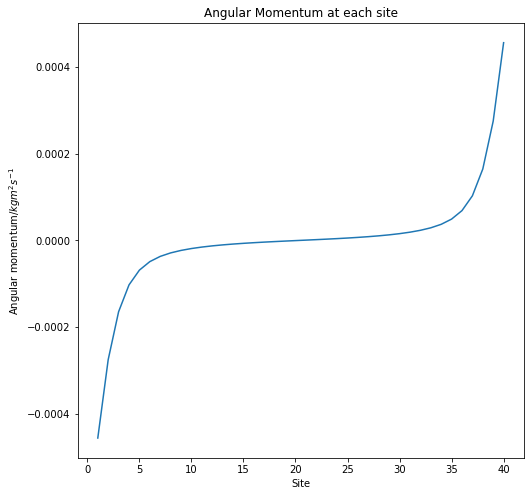

In [192]:
import matplotlib.pyplot as plt
x = np.arange(1,L+1)
y = np.real(M)
fig, ax = plt.subplots()
plt.xlabel("Site")
plt.ylabel("Angular momentum/$kgm^2s^{-1}$")
plt.title("Angular Momentum at each site")
plt.rcParams["figure.figsize"] = (8,8)
line1, = ax.plot(x, y)
